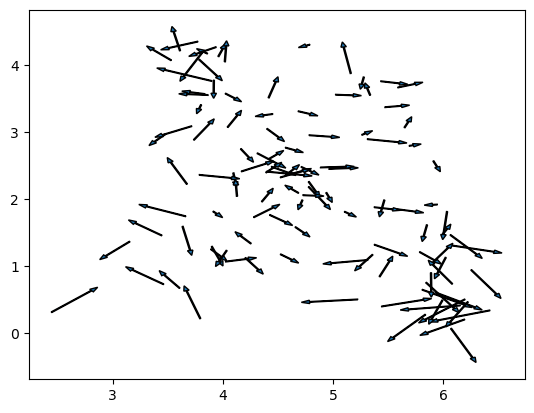

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pycircstat.descriptive import mean as cmean, resultant_vector_length
import numpy as np
df = pd.read_csv('data/statemaps.txt')

figall, axall = plt.subplots()

allsids = np.unique(df[' sid'])
for i in range(allsids.shape[0]):

    sid = allsids[i]
    subdf = df[df[' sid'] == sid]
    x = subdf['x'].to_numpy()
    y = subdf['y'].to_numpy()
    a = subdf['rota'].to_numpy() * subdf['rotz'].to_numpy()
    xmu, ymu = x.mean(), y.mean()
    amu = cmean(a)
    rmu = resultant_vector_length(a)
    # axall.scatter(xmu, ymu)
    r = 0.5 * rmu
    axall.arrow(xmu, ymu, r * np.cos(amu), r * np.sin(amu) , width =0.01, head_width=0.05)
    # fig, ax = plt.subplots()
    # ax.quiver(x, y, np.cos(a), np.sin(a))
    # axall.set_xlim(-7, 7)
    # axall.set_ylim(-3, 5)

In [16]:
import numpy as np
from hipposlam.utils import read_pickle, save_pickle
from hipposlam.sequences import Sequences
from hipposlam.comput_utils import circular_gau_filter, divide_ignore, midedges, Arena
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import os
import matplotlib as mpl
from matplotlib import cm
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy.special import factorial
def logPois(r, k, epsilon=1e-6):
    out = k * np.log(r+epsilon) - (r+epsilon) - factorial(k)
    return out


In [17]:

# Paths and data===============
debug_plot_tag = True
project_tag = 'Avoidance_CloseObjs'
data_dir = join('data', project_tag)
plot_dir = join('plots', project_tag, 'BayesianDecoding')
os.makedirs(plot_dir, exist_ok=True)
trajdata = read_pickle(join(data_dir, 'traj.pickle'))
metadata = read_pickle(join(data_dir, 'meta.pickle'))
seqR = metadata['seqR']
seqL = metadata['seqL']
fkey2id_dict = metadata['stored_f']
id2fkey_dict = {val:key for key, val in fkey2id_dict.items()}
f_pos = metadata['fpos']
trajdf = pd.DataFrame(trajdata)
trajdf['X_Nrow'] = trajdf['X'].apply(lambda x : x.shape[0])
trajdf['a'] = trajdf['rota'] * trajdf['rotz']


In [23]:

trajdf['f_sigma'][1000]

{'15833': [],
 '15717': [],
 '14245': [],
 '15696': [],
 '15794': [],
 '14469': [],
 '1629': [],
 '2637': [],
 '1853': [],
 '15570': [],
 '15612': [],
 '5540': [],
 '2714': [],
 '4206': [],
 '1375': []}

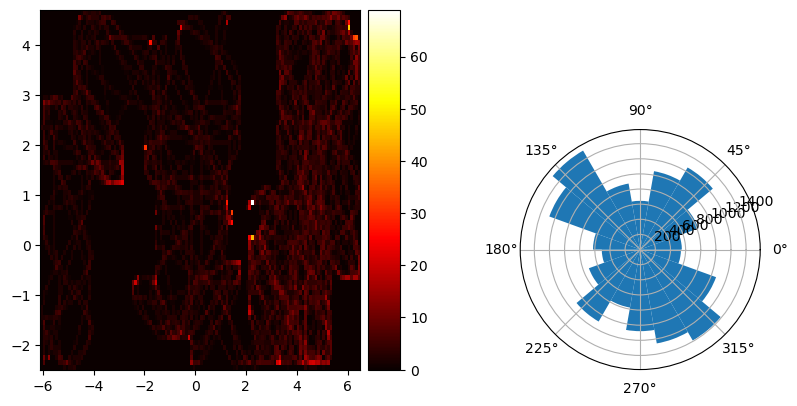

In [50]:

# Occpancy ===========================
bodysd = 0.15  # body length of the robot = 0.3m
dp = 0.1
da = 2*np.pi/18
xmin = np.floor(trajdf['x'].min() * 10) / 10
xmax = np.ceil(trajdf['x'].max() * 10) / 10
ymin = np.floor(trajdf['y'].min() * 10) / 10
ymax = np.ceil(trajdf['y'].max() * 10) / 10
amin, amax = -np.pi, np.pi

BD = Arena(xmin, xmax, ymin, ymax, amin, amax, dp, da, bodysd)
occ, edges3d = BD.compute_histogram3d(trajdf['x'].to_numpy(), trajdf['y'].to_numpy(), trajdf['a'].to_numpy())
occ_p = occ.sum(axis=2)
occ_a = occ.sum(axis=0).sum(axis=0)
if debug_plot_tag:
    fig = plt.figure(figsize=(8, 4), facecolor='w')
    ax1 = fig.add_axes([0, 0, 0.4, 0.9])
    ax2 = fig.add_axes([0.6, 0, 0.3, 0.6], polar=True)
    cbar_ax = fig.add_axes([0.41, 0, 0.04, 0.9])
    im1 = ax1.pcolormesh(BD.xedges, BD.yedges, occ_p.T, cmap='hot')
    cb = fig.colorbar(im1, cax=cbar_ax)
    ax2.bar(BD.aedm, occ_a, width=da)
    # fig.savefig(join(plot_dir, 'Occupancy.png'))

In [51]:

# Organize Spike Data ====================
Num_Fnodes = trajdf['X_Nrow'].max()
xdict = dict()
ydict = dict()
adict = dict()
fposdict = dict()
for i in range(trajdf.shape[0]):

    Xmat = trajdf['X'][i]
    x = trajdf['x'][i]
    y = trajdf['y'][i]
    a = trajdf['a'][i]

    if Xmat.shape[0] < 1:
        continue
    fnode_ids, sigma_ids = Sequences.X2sigma(Xmat, seqR, sigma_state=False)

    for fnode_id, sigma_id in zip(fnode_ids, sigma_ids):
        nodekey = id2fkey_dict[fnode_id]
        ensem_key = '%s-%d'%(nodekey, sigma_id)

        fposdict[ensem_key] = f_pos[nodekey.split('_')[0]]

        if ensem_key in xdict:
            xdict[ensem_key].append(x)
            ydict[ensem_key].append(y)
            adict[ensem_key].append(a)

        else:
            xdict[ensem_key] = [x]
            ydict[ensem_key] = [y]
            adict[ensem_key] = [a]
